## Calcul de $\pi$

Implémenter le calcul de $\pi$ par la méthode de Monte Carlo

100%|██████████| 1000000/1000000 [00:05<00:00, 172449.00it/s]


Approximation de pi après 1000000 tirages : 3.141728


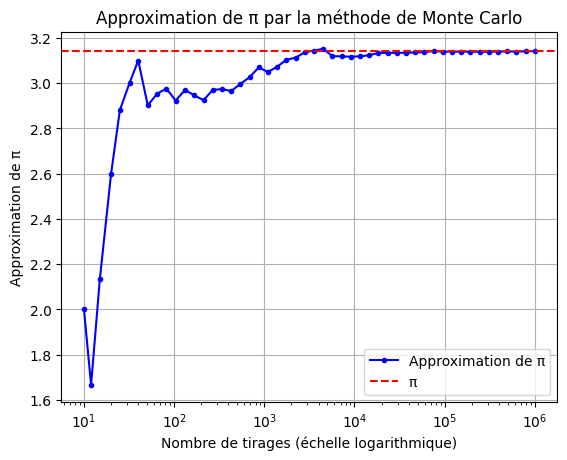

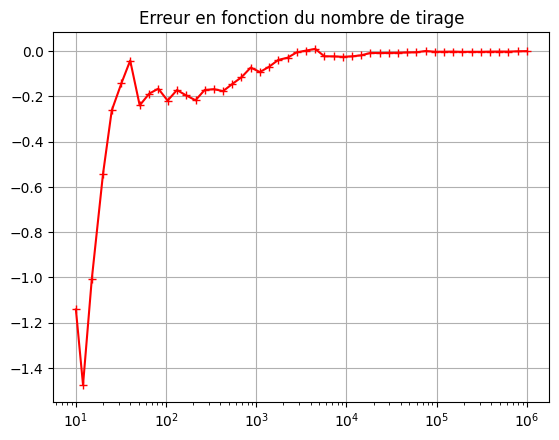

In [ ]:
import numpy as np  
import matplotlib.pyplot as plt
from tqdm import tqdm

nombre_de_tirages = int(1e6)

# Preparer une echelle log pour l'affichage de pi par la methode de Monte Carlo
Tx=np.logspace(1, np.log10(nombre_de_tirages-1), num=50, dtype=int)
Ty=np.zeros_like(Tx, dtype=float)
# On va compter le nombre de bon tirage
nombre_de_bons_tirages = 0
for i in tqdm(range(nombre_de_tirages)): 
    # On procède à deux tirages entre 0 et 1 avec une valeur uniforme
    x,y= np.random.uniform(0,1,2) 
    # Si la norme est inférieur à 1, alors on est dans le cercle donc le tirage est bon
    if x**2 + y**2 <= 1:
        nombre_de_bons_tirages += 1

    # Stockage des valeurs pour l'affichage de l'évolution de l'approximation
    if i in Tx:
        Ty[np.where(Tx==i)[0][0]] =  nombre_de_bons_tirages / i

pi_approximation = nombre_de_bons_tirages / nombre_de_tirages
print("Approximation de pi après", nombre_de_tirages, "tirages :", pi_approximation)

# Ty = Ty - np.pi
plt.figure()
plt.xscale('log')
plt.plot(Tx, Ty, marker='.', linestyle='-', color='b', label='Approximation de π')
plt.axhline(np.pi, color='r', linestyle='--', label='π')
plt.xlabel('Nombre de tirages (échelle logarithmique)')
plt.ylabel('Approximation de π')
plt.title('Approximation de π par la méthode de Monte Carlo')
plt.legend()
plt.grid()
plt.show(block=False)

# Affichage de l'erreur en fonction du nombre de tirages
erreur = Ty-np.pi
plt.plot(Tx,erreur,'r+-')
plt.xscale('log')
plt.grid()
plt.title("Erreur en fonction du nombre de tirage")
# plt.legend()
plt.show()

# La méthode Monte Carlo appliquée au transport de particules

Considérons la configuration suivante 
- Une géométrie sphérique de rayon $R$.  
- Un matériau contenant un seul isotope (U235) dont les sections et la densité sont données dans la classe `NuclearData`. 

L'exercice consiste à construire une simulation Monte Carlo afin de 
1. Déterminer le $keff$ pour un rayon $R=1$.  
2. Déterminer le rayon critique; $R$ tel que $keff=1$.
3. Déterminer la masse critique
4. Pour le rayon critique, calculer et tracer le flux en fonction du rayon, et estimer les fuites du système.  
5. Tracer le keff en fontion du nombre de batch, Après combien de générations a-t-on atteint la stationnarité ?  
Expliquer l’origine de la non-stationnarité lors des premières générations simulées.

Pour cela, nous considérerons que 
- le noyau ne possède que 3 réactions : Fission, Capture et diffusion.  
- Le système est "mono-cinétique";  i.e. les neutrons ne changent pas d'énergie et les sections ont toujours la même valeur.
- Les neutrons sont placés initialement au centre de la sphère (on peut la considérer centrée en (0,0,0))

Ensuite, vous pouvez implémenter la simulation de la vie d'un neutron (vol, fuite, collision) pour enfin organiser le système selon la "boucle critique". 
Pour cela, vous pouvez vous appuyez sur les classes (partiellement) définies ci-dessous : `NuclearData`, `GeometrySphere`, `Neutron`.   
Quelques fonctions ont été "définies" (mais vide), je vous conseille de les remplir et les utiliser afin de structurer votre code.  
Ces fonctions sont : `sample_interaction`, `sample_uniform_direction`, `get_distance_to_boundary`, `sample_distance_to_interaction`, `simulate_neutron`.  

Les fonctions suivantes de numpy pourraient être utiles : `np.random.uniform`, `np.roots`, les fonctions classiques (`np.cos`, `np.log`, ....), `np.mean` et `np.std` (utiliser l'option `ddof=1` pour la correction de Bessel).

## Quelques données 

100%|██████████| 110/110 [00:00<00:00, 959196.34it/s]


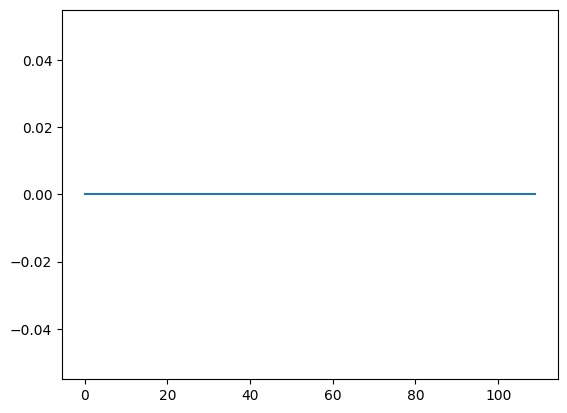

In [ ]:
from dataclasses import dataclass, field
import numpy as np
import copy

from tqdm import tqdm
import multiprocessing
from multiprocessing import Pool
processes=multiprocessing.cpu_count()


@dataclass
class NuclearData:
    atomic_weight_ratio: float = 235.0
    density: float = 4.4994e-02  # at. / barn.cm
    xs_capture: float = 0.0599268
    xs_elastic: float = 3.78266
    xs_fission: float = 1.2885
    nu_bar: float = 2.64574
    xs_total: float = field(init=False)

    def __post_init__(self):
        self.xs_total = self.xs_capture + self.xs_elastic + self.xs_fission

    def get_macro_xs(self, reaction):
        return self.density * self.get_xs(reaction)

    def get_xs(self, reaction):
        if reaction.lower() == "capture":
            return self.xs_capture
        if reaction.lower() == "fission":
            return self.xs_fission
        if reaction.lower() == "elastic":
            return self.xs_elastic
        if reaction.lower() == "total":
            return self.xs_total
        raise ValueError(
            f"Reaction {reaction} is not accepted. Accepted values are: capture, fission, elastic, total"
        )

    def sample_interaction(self):
        """ Select the interaction : return string : 'capture', ... 
        """
        interactions=['capture', 'fission', 'elastic']
        probabilities=[self.xs_capture/self.xs_total, self.xs_fission/self.xs_total, self.xs_elastic/self.xs_total]
        return np.random.choice(interactions, probabilities)
        # pass


def sample_uniform_direction():
    """ Sample a uniform direction 
    """
    return np.random.uniform(-1, 1, 3)  
    # pass


@dataclass
class GeometrySphere:
    radius: float = 1
    center: np.ndarray = field(default_factory=lambda: np.zeros(3))

    def get_distance_to_boundary(self, pos, dir):
        """
        Compute the exiting distance from the sphere for a particle at position 'pos' with direction 'dir'
        """
        distance = np.linalg.norm(pos-dir)
        return distance
        pass


@dataclass
class Neutron:
    position: np.ndarray
    direction: np.ndarray

    def __post_init__(self):
        self._normalize_direction()

    def _normalize_direction(self):
        norm = np.linalg.norm(self.direction)
        self.direction /= norm

    def set_direction(self, angle):
        self.direction = angle
        self._normalize_direction()

    def move_distance(self, distance):
        self.position += self.direction * distance


def sample_distance_to_interaction(sigma_t):
    """
    Sample the distance to the next interaction from the total cross section
    """
    pass


def simulate_neutron(neutron, geom, data):
    """
    Simulate the life of a neutron. 
    Eventually return fission neutrons in a list if a fission happened
    """
    pass


# rayon pour démarrer
rayon = 1.0  # cm
np.random.seed(0)
data = NuclearData()
geometry = GeometrySphere(radius=rayon)
nb_neutrons_per_batch = 10000
nb_batches = 110
starting_neutrons = [Neutron(np.zeros(3), sample_uniform_direction()) for i in range(nb_neutrons_per_batch)]
keff = np.zeros(nb_batches)

for batch in tqdm(range(nb_batches)):
    with Pool(processes) as pool:
        results = list(tqdm(pool.imap(simulate_neutron, [Neutron,geometry,data] * nb_neutrons_per_batch), total=nb_neutrons_per_batch))

    




import matplotlib.pyplot as plt

plt.plot(keff)